In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import cv2

base_dir = '/kaggle/input/histopathologic-cancer-detection/'
print(os.listdir(base_dir))

# Import PyTorch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torch.optim as optim

# Import useful sklearn functions
import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score
from PIL import Image

['sample_submission.csv', 'train_labels.csv', 'test', 'train']


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Loading Data and EDA

Just like any other image classification problem we have a csv file with image ids and labels. The directories train, test contain the actual images.

In [2]:
full_train_df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")
full_train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [3]:
print("Train Size: {}".format(len(os.listdir('/kaggle/input/histopathologic-cancer-detection/train/'))))
print("Test Size: {}".format(len(os.listdir('/kaggle/input/histopathologic-cancer-detection/test/'))))

Train Size: 220025
Test Size: 57458


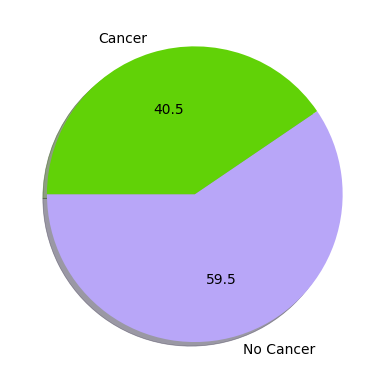

<Figure size 1600x1600 with 0 Axes>

In [4]:
labels_count = full_train_df.label.value_counts()

%matplotlib inline
plt.pie(labels_count, labels=['No Cancer', 'Cancer'], startangle=180, 
       autopct='%1.1f', colors=['#b8a6f8', '#61d207'], shadow=True)
plt.figure(figsize=(16, 16))
plt.show()


# Visualizing Images

Classifying metastases is probably not an easy task for a train pathologist and extremely difficult for an untrain eye when we take a look at the image.

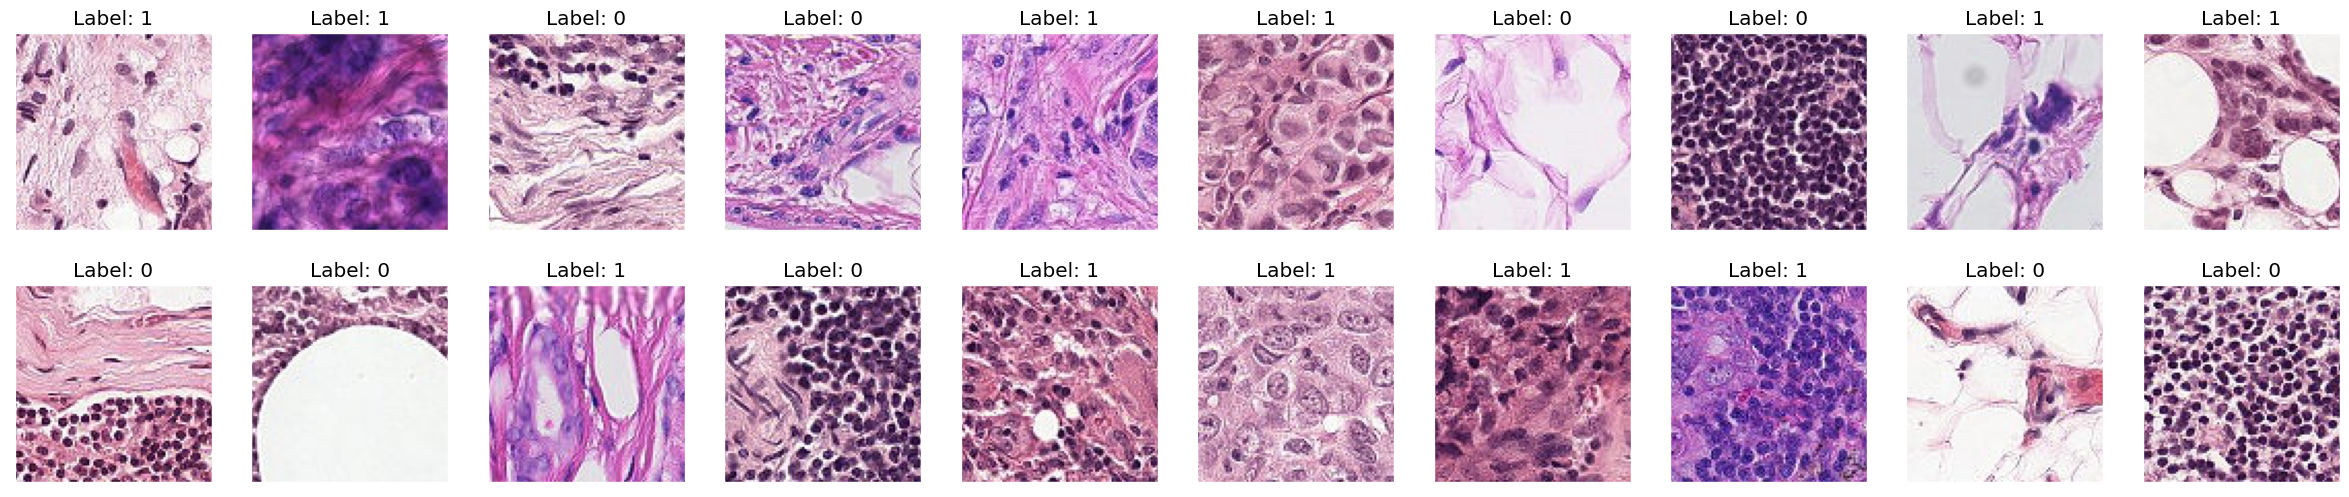

In [5]:
fig = plt.figure(figsize=(30, 6))

# Displaying 20 images
train_imgs = os.listdir(base_dir + 'train')
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx + 1, xticks=[], yticks=[])
    im = Image.open(base_dir + 'train/' + img)
    plt.imshow(im)
    lab = full_train_df.loc[full_train_df['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title('Label: %s'%lab)

# Sampling

Since the train dataset contains 2,20,025 images, we can sample out a shuffled part of that, in this case 1,60,000 samples and train on them to make predictions later.

In [6]:
# Number of samples in each class
SAMPLE_SIZE = 80000

# Data paths
train_path = '/kaggle/input/histopathologic-cancer-detection/train/'
test_path = '/kaggle/input/histopathologic-cancer-detection/test/'

# Use 80000 positive and negative examples
df_negatives = full_train_df[full_train_df['label'] == 0].sample(SAMPLE_SIZE, random_state=42)
df_positives = full_train_df[full_train_df['label'] == 1].sample(SAMPLE_SIZE, random_state=42)

# Concatenate the two dfs and shuffle them up
train_df = sklearn.utils.shuffle(pd.concat([df_positives, df_negatives], axis=0).reset_index(drop=True))

train_df.shape

(160000, 2)

# Data Pre-processing for PyTorch

First we turn our data into PyTorch dataset, then the data is sampled into train and validation sets. Data Augmentations are added for train data to improve performance.

In [7]:
# Custom class for datasets
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = './', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform
        
    def __len__(self):
            return len(self.df)
        
    def __getitem__(self, index):
        img_name, label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name + '.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [9]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = CreateDataset(df_data = train_df, data_dir = 
                    train_path, transform=transforms_train)

In [10]:
# Set Batch Size
batch_size = 128

# Percentage of training set to use as validation
valid_size = 0.1

# Obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Create Samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Prepare data loaders (Combine dataset and sampler)
train_loader = DataLoader(train_data, 
            batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_data,
            batch_size=batch_size, sampler=valid_sampler)

In [12]:
transforms_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Creating test data
sample_sub = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
test_data = CreateDataset(df_data = sample_sub, 
                  data_dir=test_path, transform=transforms_test)

# Prepare the test loader
test_loader = DataLoader(test_data, batch_size=batch_size,
                        shuffle=False)

# Defining Model Architecture

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Convolutional and Pooling Layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32,
                     kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2))
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64,
                     kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2))
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128,
                     kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2))

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256,
                     kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2))

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512,
                     kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2))

        self.dropout2d = nn.Dropout2d()
        
        self.fc = nn.Sequential(
            nn.Linear(512*3*3, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.Dropout(0.4),
            nn.Linear(512, 1),
            nn.Sigmoid())
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [14]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print("Training on CPU")
else:
    print('Training on GPU')

Training on GPU


# Training and Validation

In [15]:
# Create a complete CNN
model = CNN()
print(model)

if train_on_gpu: model.cuda()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [17]:
# Trainable Parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters: \n{}'.format(pytorch_total_params))

Number of trainable parameters: 
6805249


In [18]:
# Specify Loss function (categorical cross-entropy loss)
criterion = nn.BCELoss()

# Specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00015)

In [19]:
# Number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf

# Keeping track of losses as it happen
train_losses = []
valid_losses = []
val_auc = []
test_accuracies = []
valid_accuracies = []
auc_epoch = []

for epoch in range(1, n_epochs+1):
    # Keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # Train the model
    model.train()
    for data,target in train_loader:
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
            target = target.view(-1, 1)
            
            # Clear the gradient of all optimized variables
            optimizer.zero_grad()
            
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            # Calculate the batch loss
            loss = criterion(output, target)
            
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            
            # Perform a single optimization step (parameter update)
            optimizer.step()
            
            # Update Train loss and accuracies
            train_loss += loss.item() * data.size(0)
            
            
    # Validate the model
    model.eval()
    for data, target in valid_loader:
        # Mode tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()

            # Forward pass: compute predicted outputs by passing inputs to the model
            target = target.view(-1, 1)
            output = model(data)
            
            # Calculate the batch loss
            loss = criterion(output, target)
            
            # Update average validation loss 
            valid_loss += loss.item()*data.size(0)
            
            # Output = output.topk()
            y_actual = target.data.cpu().numpy()
            y_pred = output[:,-1].detach().cpu().numpy()
            val_auc.append(roc_auc_score(y_actual, y_pred))        
    
    # Calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_auc = np.mean(val_auc)
    auc_epoch.append(np.mean(val_auc))
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # Print training/validation statistics 
    print('Epoch: {} | Training Loss: {:.6f} | Validation Loss: {:.6f} | Validation AUC: {:.4f}'.format(
        epoch, train_loss, valid_loss, valid_auc))
    
    # Early Stopping 
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'best_model.pt')
        valid_loss_min = valid_loss

Epoch: 1 | Training Loss: 0.361017 | Validation Loss: 0.393116 | Validation AUC: 0.9414
Validation loss decreased (inf --> 0.393116).  Saving model ...
Epoch: 2 | Training Loss: 0.295677 | Validation Loss: 0.272743 | Validation AUC: 0.9489
Validation loss decreased (0.393116 --> 0.272743).  Saving model ...
Epoch: 3 | Training Loss: 0.264321 | Validation Loss: 0.246609 | Validation AUC: 0.9550
Validation loss decreased (0.272743 --> 0.246609).  Saving model ...
Epoch: 4 | Training Loss: 0.237364 | Validation Loss: 0.221505 | Validation AUC: 0.9589
Validation loss decreased (0.246609 --> 0.221505).  Saving model ...
Epoch: 5 | Training Loss: 0.218411 | Validation Loss: 0.198898 | Validation AUC: 0.9624
Validation loss decreased (0.221505 --> 0.198898).  Saving model ...
Epoch: 6 | Training Loss: 0.205315 | Validation Loss: 0.213974 | Validation AUC: 0.9642
Epoch: 7 | Training Loss: 0.197012 | Validation Loss: 0.207686 | Validation AUC: 0.9658
Epoch: 8 | Training Loss: 0.186392 | Validat

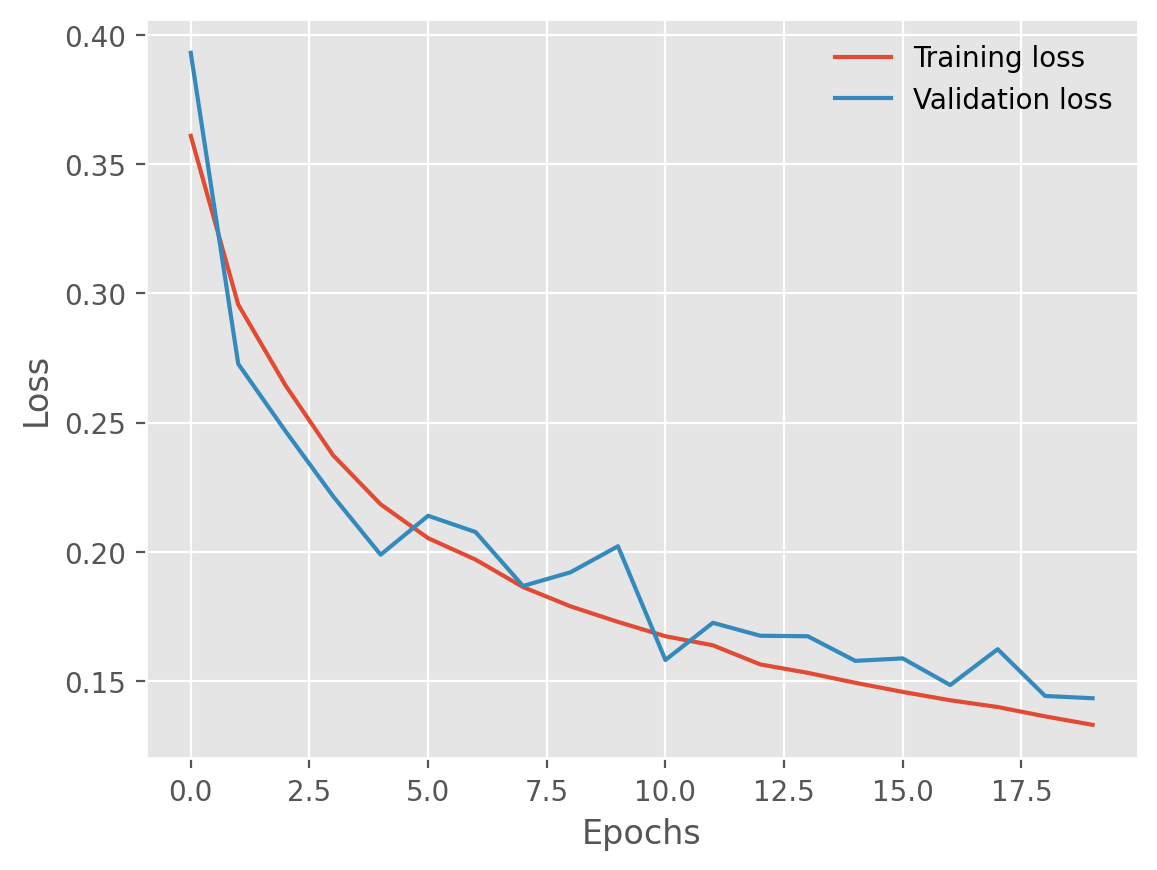

In [20]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

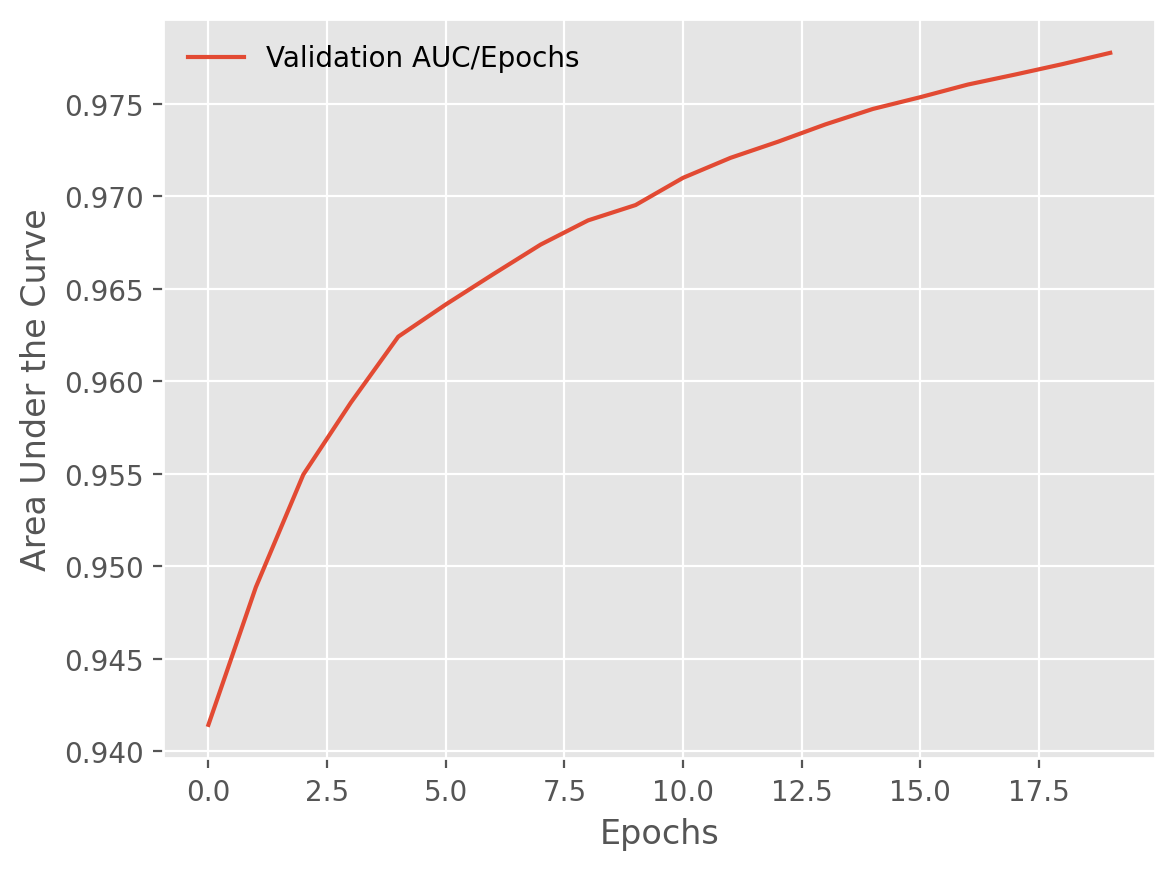

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(auc_epoch, label='Validation AUC/Epochs')
plt.legend("")
plt.xlabel("Epochs")
plt.ylabel("Area Under the Curve")
plt.legend(frameon=False)

In [22]:
# Load Best parameters learned from training into our model to make predictions later
model.load_state_dict(torch.load('/kaggle/working/best_model.pt'))

<All keys matched successfully>